# Tensor Train Optimization Tutorial

This library includes extensible functionality for directly optimizing tensor
trains. 

Suppose we want to optimize a tensor train `tt` to minimize some function
`f(tt)`. Using automatic differentiation, we would be able to automatically
compute the gradients of this function in all of the entries of `tt`. This is
however not a good idea; there are many symmetries in the tensor train format
and this approach works very badly in practice.

Instead we optimize tensor trains using Riemannian (conjugate) gradient descent.
It turns out that Riemannian gradients for tensor trains can be computed
relatively efficiently, and they provide faster and more numerically stable
convergence.


## Tensor completion


Specifically for the problem of solving the tensor completion problem we have
implemented the `TensorTrainLineSearch` class. Below we see it in action:

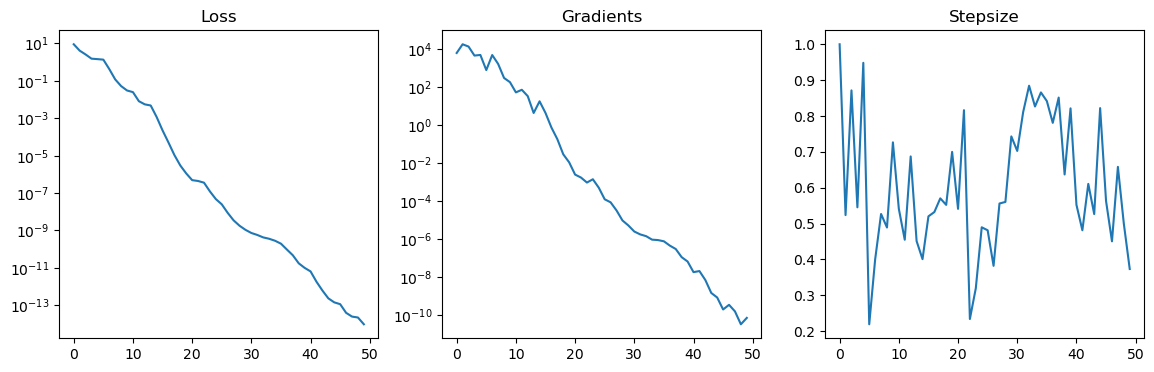

In [1]:
from ttml.tensor_train import TensorTrain
from ttml.tt_rlinesearch import TensorTrainLineSearch
import matplotlib.pyplot as plt
import numpy as np

# Create a dummy problem
dims = (5, 4, 5, 10)
N = 1000
# Randomly choose indices
idx = np.stack([np.random.choice(d, size=N) for d in dims], axis=1)
y = np.exp(np.sum(idx, axis=1) / 10)  # Function is exp sum

# Initialize random tensor train with rank 2
tt = TensorTrain.random(dims, 2)

# Initialize an optimizer for the tensor train completion problem
optim = TensorTrainLineSearch(tt, y, idx, task="regression")


# Do 50 steps of optimization
losses = []
grads = []
stepsizes = []
for i in range(50):
    loss, grad, stepsize = optim.step()
    losses.append(loss)
    grads.append(-grad)
    stepsizes.append(stepsize)

# Plot the results
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Loss")
plt.yscale("log")
plt.plot(losses)
plt.subplot(1, 3, 2)
plt.title("Gradients")
plt.plot(grads)
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.title("Stepsize")
plt.plot(stepsizes)
plt.show()

We see that the loss is quickly and linearly convergening to 0. This is because
the underlying function can be exactly represented by a rank 2 tensor train.

This optimization problem minimizes a mean squared error. For classification
problems we may want to minimize cross entropy loss instead. This can be done by
supplying the `task="classification"` keyword argument. Below we solve a simple
classification problem, but in this case convergence is even faster so we only
do 10 steps.

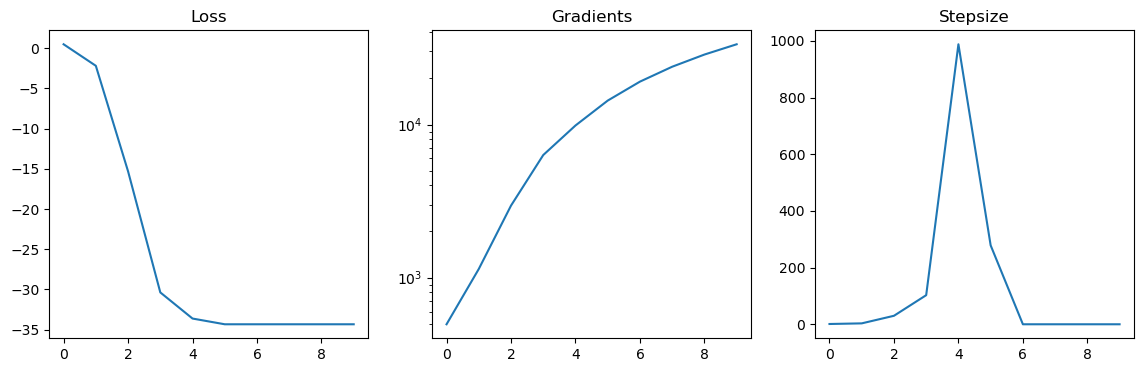

In [2]:
# Reuse previous y to create ballanced classification problem
y_classification = (y > np.median(y)).astype(int)

# Initialize random tensor train with rank 2
tt = TensorTrain.random(dims, 2)

# Initialize an optimizer for the tensor train completion problem
optim = TensorTrainLineSearch(tt, y, idx, task="classification")


# Do 10 steps of optimization
losses = []
grads = []
stepsizes = []
for i in range(10):
    loss, grad, stepsize = optim.step()
    losses.append(loss)
    grads.append(-grad)
    stepsizes.append(stepsize)

# Plot the results
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Loss")
# plt.yscale("log")
plt.plot(losses)
plt.subplot(1, 3, 2)
plt.title("Gradients")
plt.plot(grads)
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.title("Stepsize")
plt.plot(stepsizes)
plt.show()

## Parameters for TensorTrainLineSearch

There are many options for `TensorTrainLineSearch`. We highlight the most important ones.

- `sample_weights`  
    We can associate a positive weight for each sample. This affects both the loss and the
    gradient, and is useful for example for unbalanced datasets.
- `cg_method`  
    Above we have used Fletcher-Reeves conjugate gradient descent
    (`cg_method='fr'`). We can also use steepest descent (`cg_method='sd'`),
    which is slightly faster per step but in general has slower convergence. For
    Fletcher-Reeves we need to compute the parallel transport of the search
    direction at each step, which is not necessary for steepest descent.
- `line_search_method`  
    To determine the stepsize, we use the Armijo conidition by default
    (`line_search_method='armijo'`). However we can use the (strong) Wolfe
    condition instead by using `line_search_method='wolfe'`.
- `memory`  
    If `memory > 1`, then we use nonmonotone line search. This means we only require the loss to decrease every `memory` steps. 
- `max_stepsize`  
    Limit the maximum stepsize. This can help sometimes with overfitting, but
    requires specific tuning for each problem. By default the stepsize is unbounded.
- `initial_stepsize_method`  
    The Armijo and Wolfe line searches both require an initial stepsize. In
    principle we want that the initial step size satisfies the Armijo/Wolfe
    conditions, to limit the number of function evaluations required. However,
    we also want the stepsize to be as large as possible to speed up
    convergence. All in all this means that the initial step size can have a
    significant impact on convergence speed. 
    
    By default we choose the type-1 Barzilai-Borwein stepsize (`'bb1'`), but we
    also support the type-2 BB stepsize (`'bb2'`). Furthemore we have the
    Quasi-optimal stepsize based on a linearization of the loss function, as
    proposed by Steinlechner (`'qopt'`). Finally with `'scalar'` we the take
    twice the difference between current and previous loss value, divided by the
    derivative of the line search function.
- `auto_scale`  
    If the optimial stepsize is very large, it can take the optimizer quite a
    few steps to start using good stepsizes. To avoid this situation, we can set
    `auto_scale=True`, which uses the norm of the gradient to better estimate on
    what scale we should choose the stepsize. This only affects the first step
    size. This is sometimes necessary for optimizing cross entropy loss. 

## Stochastic gradient descent

The computation time for each step of gradient descent roughly scales linearly
with the number of data points. Therefore if we have a very large number of data
points, it makes sense to use stochastic gradient descent to speed things up. In
theory stochastic gradient descent can also act as a regularizer. For this
purpose we have implemented the Riemannian ADAM stochastic gradient descent
algorithm. 

Below we consider the same dummy problem as before, but now with many more
datapoints. We do stochastic gradient descent with a batch size of `1000`, for
one epoch of training. Note that batch size can be chosen relatively large,
easily up to `10 000`. If the batch size is much smaller, then the computation
time is dominated by orthogonalization of the tensor trains each step.

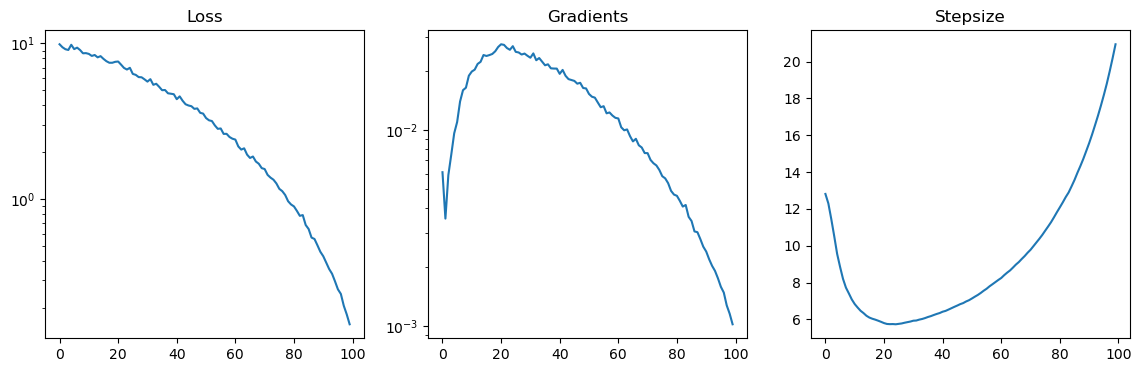

In [3]:
from ttml.tt_radam import TensorTrainSGD

# Create a dummy problem
dims = (5, 4, 5, 10)
N = 100000
# Randomly choose indices
idx = np.stack([np.random.choice(d, size=N) for d in dims], axis=1)
y = np.exp(np.sum(idx, axis=1) / 10)  # Function is exp sum

# Initialize random tensor train with rank 3
tt = TensorTrain.random(dims, 3)

# Initialize an optimizer for the tensor train completion problem
optim = TensorTrainSGD(tt, y, idx, batch_size=1000, task="regression")

losses = []
grads = []
stepsizes = []
for i in range(100):
    loss, grad, stepsize = optim.step()
    losses.append(loss)
    grads.append(-grad)
    stepsizes.append(stepsize)

# Plot the results
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Loss")
plt.yscale("log")
plt.plot(losses)
plt.subplot(1, 3, 2)
plt.title("Gradients")
plt.plot(grads)
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.title("Stepsize")
plt.plot(stepsizes)
plt.show()

## Extending with new loss functions

By default we can only use mean squared error loss and cross entropy loss for 
the tensor completion problem. We can easily extend the optimizer to use new
loss functions. As an example we will show how to implement mean squared error
loss with an L2 regularizer.

To do this we need to define two functions: `my_loss(tt, y, idx, **kwargs)` and
`my_egrad(tt, y, idx, **kwargs)`. Here `my_loss` should return the error we try to
minimize, and `my_egrad` should return the _Euclidean gradient_ of the function.
By the Euclidean gradient we mean the sparse gradient of `my_loss` seen as a
function of the dense tensor represented by `tt`. There will be one gradient
value for each index stored in `idx`. 

A simple implementation of these two functions is given below. Note that `my_egrad` should both return the Euclidean gradient _and_ the loss value.

In [4]:
def my_loss(tt, y, idx, **kwargs):
    prediction = tt.gather(idx)
    loss_mse = np.sum((prediction - y) ** 2)
    loss_l2 = np.linalg.norm(prediction) ** 2
    loss = loss_mse + 1e-4 * loss_l2
    return loss


def my_egrad(tt, y, idx, **kwargs):
    prediction = tt.gather(idx)

    loss_mse = np.sum((prediction - y) ** 2)
    loss_l2 = np.linalg.norm(prediction) ** 2
    loss = loss_mse + 1e-4 * loss_l2

    egrad_mse = 2 * (prediction - y)
    egrad_l2 = 2 * np.abs(prediction)
    egrad = egrad_mse + 1e-4 * egrad_l2
    return loss, egrad


Now to use this in `TensorTrainLineSearch` or `TensorTrainSGD` we need to tell
the meta tensor train optimization class, `TensorTrainOptimizer` where to look.
We do this by adding these functions to the dictionaries
`tt_opt._loss_func_dict` and `tt_opt._egrad_func_dict`. After that we can use it
simply by setting the `task=` keyword argument to the appropriate value.

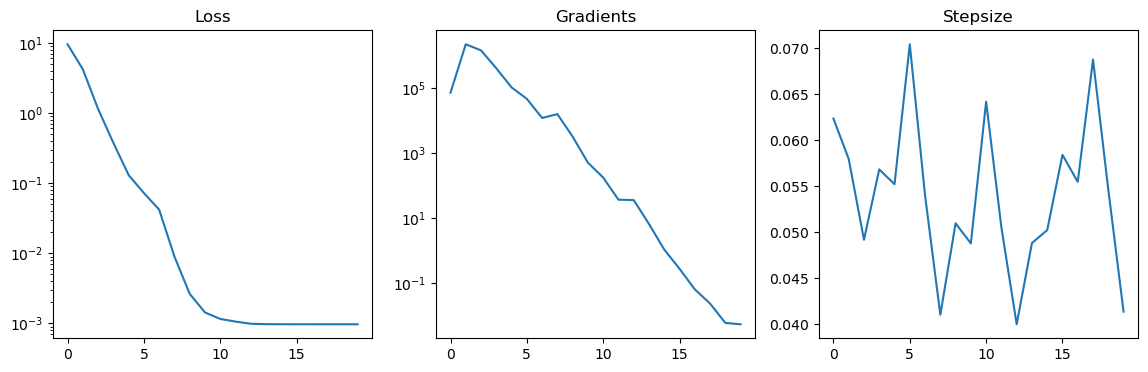

In [5]:
from ttml import tt_opt

# Register the new loss and egrad
tt_opt._loss_func_dict["my_task"] = my_loss
tt_opt._egrad_func_dict["my_task"] = my_egrad

# Create a dummy problem
dims = (5, 4, 5, 10)
N = 10000
idx = np.stack([np.random.choice(d, size=N) for d in dims], axis=1)
y = np.exp(np.sum(idx, axis=1) / 10) 

# Initialize random tensor train with rank 3
tt = TensorTrain.random(dims, 3)

optim = TensorTrainLineSearch(tt, y, idx, task="my_task")

losses = []
grads = []
stepsizes = []
for i in range(20):
    loss, grad, stepsize = optim.step()
    losses.append(loss)
    grads.append(-grad)
    stepsizes.append(stepsize)

# Plot the results
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Loss")
plt.yscale("log")
plt.plot(losses)
plt.subplot(1, 3, 2)
plt.title("Gradients")
plt.plot(grads)
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.title("Stepsize")
plt.plot(stepsizes)
plt.show()

This is the basic functionality, but there three small things we might want
to do to improve functionality. 

**Normalization**  
The first is for reporting; above the loss function is the square error loss,
not the _mean_ squared error loss. The difference is a factor of `len(y)`.
During optimization it is in general better to use the unormalized version, but
for reporting the loss to the user the normalized version makes more sense. The
optimizer uses the appropriate version automatically by supplying the
`normalize` keyword to `my_loss` and `my_egrad`. 

**Sample weights**  
The optimizer passes sample weights to the loss and egrad functions through the
`sample_weight` keyword. In this case we need to be slightly careful, since the
sample weights affect `loss_mse` and `egrad_mse`, but not `loss_l2` and
`egrad_l2`.

**Extra keyword arguments**  
Above we always added the L2-loss by multiplying it first by `1e-4`. Of course
we want the user to specify this coupling constant at runtime. To do this we can
add any keyword argument we like to `my_loss` and `my_egrad`. This argument can
then be specified by the user by adding it to `task_kwargs` when initializing
the optimizer.

Let's take all this into account and upgrade `my_loss` and `my_egrad`.

In [6]:
def my_loss(tt, y, idx, sample_weight, normalize, my_kwarg=1e-4, **kwargs):
    if sample_weight is None:
        sample_weight = 1.0

    prediction = tt.gather(idx)
    loss_mse = np.sum(((prediction - y) * sample_weight) ** 2)
    loss_l2 = np.linalg.norm(prediction) ** 2
    loss = loss_mse + my_kwarg * loss_l2

    if normalize:
        loss /= len(y)
    return loss


def my_egrad(tt, y, idx, sample_weight, normalize, my_kwarg=1e-4, **kwargs):
    if sample_weight is None:
        sample_weight = 1.0

    prediction = tt.gather(idx)
    loss_mse = np.sum(((prediction - y) * sample_weight) ** 2)
    loss_l2 = np.linalg.norm(prediction) ** 2
    loss = loss_mse + my_kwarg * loss_l2

    egrad_mse = 2 * (prediction - y) * sample_weight
    egrad_l2 = 2 * np.abs(prediction)
    egrad = egrad_mse + my_kwarg * egrad_l2

    if normalize:
        loss /= len(y)
        egrad /= len(y)
    return loss, egrad


tt_opt._loss_func_dict["my_task"] = my_loss
tt_opt._egrad_func_dict["my_task"] = my_egrad


And finally let's test this function out:

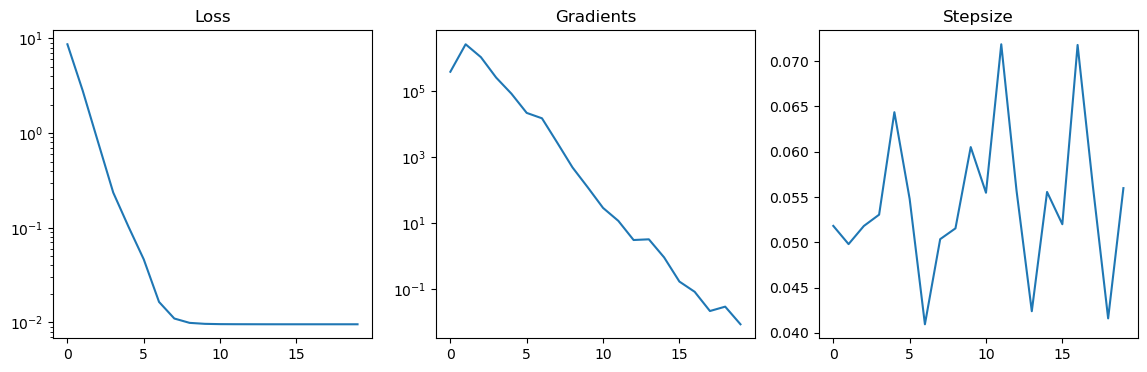

In [7]:
# Create a dummy problem
dims = (5, 4, 5, 10)
N = 10000
idx = np.stack([np.random.choice(d, size=N) for d in dims], axis=1)
y = np.exp(np.sum(idx, axis=1) / 10)

# Initialize random tensor train with rank 3
tt = TensorTrain.random(dims, 3)

optim = TensorTrainLineSearch(
    tt, y, idx, task="my_task", task_kwargs={"my_kwarg": 1e-3}
)

losses = []
grads = []
stepsizes = []
for i in range(20):
    loss, grad, stepsize = optim.step()
    losses.append(loss)
    grads.append(-grad)
    stepsizes.append(stepsize)

# Plot the results
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.title("Loss")
plt.yscale("log")
plt.plot(losses)
plt.subplot(1, 3, 2)
plt.title("Gradients")
plt.plot(grads)
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.title("Stepsize")
plt.plot(stepsizes)
plt.show()

## Verifying gradients are correct

After writing our new loss function, we want to verify the gradients are
computed correctly. A very useful tool for this is to plot the line search
function. At each point along the line search we can also compute the
derivatives, and check that the Riemannian derivatives are the same as
derivatives obtained through finite difference methods. For these debugging
purposes we can use `TensorTrainLineSearch.plot_linesearch()`. Let's do this for
the loss/egrad functions we wrote above.

It is very easy to make mistakes when defining the gradient `egrad` function, so
we strongly recommend to always do this!

In [8]:
tt = TensorTrain.random(dims, 3)

optim = TensorTrainLineSearch(
    tt, y, idx, task="my_task", task_kwargs={"my_kwarg": 1e-3}
)

stepsizes, losses, gradients = optim.plot_linesearch(plot_points=100)

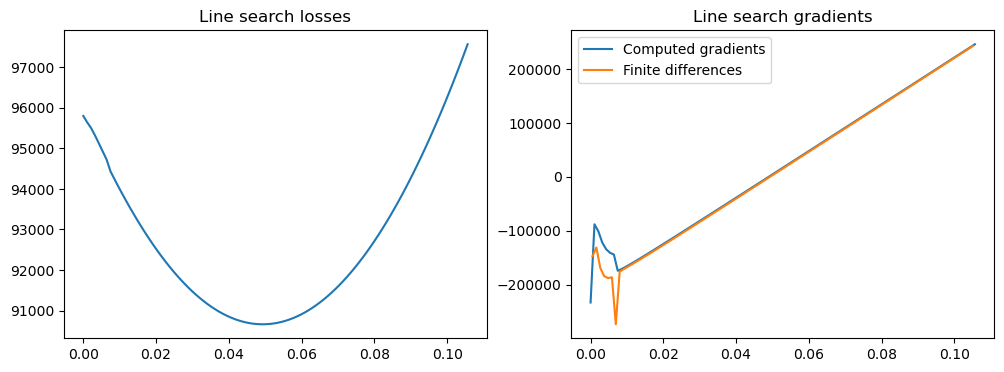

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Line search losses")
plt.plot(stepsizes, losses)

plt.subplot(1,2,2)
plt.title("Line search gradients")
plt.plot(stepsizes, gradients, label="Computed gradients")

# compute finite differences gradients
diffs = np.diff(losses)/np.diff(stepsizes)
diff_stepsizes = 0.5*stepsizes[:-1]+0.5*stepsizes[1:]
plt.plot(diff_stepsizes, diffs, label="Finite differences")
plt.legend()
plt.show()

We see that the gradients computed by the line search optimizer and the ones
computed using finite differences correspond relatively well (except for a strange peak, probably due to numerical errors). Note that it is
normal that they are not precisely the same; this is due to numerical errors on
the one hand. For larger step sizes we often see a more significant divergence.
This is because we use a retraction instead of a geodesic flow. These two tend
to differ more for larger step sizes/gradient norms, and in regions where the
manifold is more highly curved.